In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
import os
import yaml
import pickle

In [3]:
import sys
from pathlib import Path

In [4]:
from grid.policy import get_ratio
from grid.policy import occupation_measure, occupation_measure_sanity
from grid.utils import load_all
from grid.plotting import plot_policy, plot_occupation_measure, plot_reward, plot_ratio

# Notebook Sections

* * *

1. Grid world.<br>
2. Load algorithm results iteratively.<br>
3. Test configurations.<br>
4. Process results.

* * *

## 1. Grid World

* * *

Consider an $m \times n$ grid. Each tile of the grid constitutes a state. 

$$ \begin{array}{|c|c|c|}
\hline (0,0) & \cdots & (0,n-1) \\ \hline
\hline &  &  \\ \hline 
\hline (m-1,0) & \cdots & (m-1,n-1) \\
\hline
\end{array} $$

Actions are $\mathcal{A} = \{U,D,L,R,N\}$ correspond to moving *up*, *down*, *left*, *right*, or *none* for staying put. 

When possible, we move with probability $1-\delta$ under action $a=U,D,L,R$. There is a small transition probability $\delta$ to one of the other states.

The goal is to reach a pre-determined terminal cell.

* * *

## 2. Load Policy Results

Extract result objects locally or from `S3`.

In [5]:
is_local = True

Limit number of results to extract.

In [6]:
N = None

`configs` file.

In [7]:
configs_file = 'configs.yaml'

with open(configs_file,'r') as handle:
    try:
        configs = yaml.safe_load(handle)
    except yaml.YAMLError as e:
        print('({}) ERROR ... Could not load configs yaml.'.format('root'))
        raise e        

Extract result objects.

In [8]:
if is_local:
    results = load_all(root_in=configs['local']['buckets']['results'],N=N)
else:
    results = load_all(configs=configs,bucket_in='results',N=N)

In [9]:
print('Extracted {} result objects.'.format(len(results)))

Extracted 150 result objects.


In [10]:
dist_results = [res for res in results if not res['is_same']]
pareto_results = [res for res in results if res['is_same']]

In [11]:
print('Number of results for distribution experiment: {}'.format(len(dist_results)))
print('Number of results for Pareto experiment: {}'.format(len(pareto_results)))

Number of results for distribution experiment: 150
Number of results for Pareto experiment: 0


## 3. Test Configurations

In [12]:
rows = []

for result in dist_results:
    
    m = result['m']
    n = result['n']
    obstacle_num = len(result['obstacles'])    
    discount = result['discount']
    noise = result['noise']
    is_theory = result['theory']
    
    rows.append([m,n,obstacle_num,discount,noise,is_theory])
    
dist_test_configs = pd.DataFrame(rows,columns=['m','n','obstacle_num','discount','noise','is_theory'])
dist_test_configs.drop_duplicates(inplace=True)
dist_test_configs.reset_index(inplace=True,drop=True)

In [13]:
dist_test_configs

,m,n,obstacle_num,discount,noise,is_theory
0,5,5,3,0.95,0.3,False
1,5,5,3,0.95,0.2,False
2,5,5,3,0.95,0.1,False


In [14]:
rows = []

for result in pareto_results:
    
    m = result['m']
    n = result['n']
    obstacle_num = len(result['obstacles'])    
    discount = result['discount']
    noise = result['noise']
    is_theory = result['theory']
    
    rows.append([m,n,obstacle_num,discount,noise,is_theory])
    
pareto_test_configs = pd.DataFrame(rows,columns=['m','n','obstacle_num','discount','noise','is_theory'])
pareto_test_configs.drop_duplicates(inplace=True)
pareto_test_configs.reset_index(inplace=True,drop=True)

In [15]:
pareto_test_configs

,m,n,obstacle_num,discount,noise,is_theory


In [16]:
dist_test_configs['N'] = 0
dist_results_agg = {i: [] for i in dist_test_configs.index.values}
cache = [] # remove duplicates

for result in dist_results:
    
    m = result['m']
    n = result['n']
    obstacle_num = len(result['obstacles'])    
    discount = result['discount']
    noise = result['noise']
    is_theory = result['theory']
    data_id = result['policy_data_id']
    
    if (m,n,obstacle_num,discount,noise,is_theory,data_id) not in cache:
        
        index = dist_test_configs.loc[(dist_test_configs.m==m) & (dist_test_configs.n==n) 
                                 & (dist_test_configs.obstacle_num==obstacle_num) 
                                 & (dist_test_configs.discount==discount) 
                                 & (dist_test_configs.noise==noise) 
                                 & (dist_test_configs.is_theory==is_theory)].index.values[0]

        dist_results_agg[index].append(result)        
        cache.append((m,n,obstacle_num,discount,noise,is_theory,data_id))
    
    else:
        print('Removed dulpicate for m={}, n={}, obstacle_num={}, discount={}, noise={} ,is_theory={}, data_id={}.'.format(m,n,obstacle_num,discount,noise,is_theory,data_id))

for i,rs in dist_results_agg.items():
    
    test_num = len(rs)
    dist_test_configs.iloc[i,-1] = test_num


In [17]:
dist_test_configs

,m,n,obstacle_num,discount,noise,is_theory,N
0,5,5,3,0.95,0.3,False,50
1,5,5,3,0.95,0.2,False,50
2,5,5,3,0.95,0.1,False,50


In [18]:
pareto_test_configs['N'] = 0
pareto_results_agg = {i: [] for i in pareto_test_configs.index.values}
cache = [] # remove duplicates

for result in pareto_results:
    
    m = result['m']
    n = result['n']
    obstacle_num = len(result['obstacles'])    
    discount = result['discount']
    noise = result['noise']
    is_theory = result['theory']
    data_id = result['policy_data_id']
    
    if (m,n,obstacle_num,discount,noise,is_theory,data_id) not in cache:
        
        index = pareto_test_configs.loc[(pareto_test_configs.m==m) & (pareto_test_configs.n==n) 
                                 & (pareto_test_configs.obstacle_num==obstacle_num) 
                                 & (pareto_test_configs.discount==discount) 
                                 & (pareto_test_configs.noise==noise) 
                                 & (pareto_test_configs.is_theory==is_theory)].index.values[0]

        pareto_results_agg[index].append(result)
        cache.append((m,n,obstacle_num,discount,noise,is_theory,data_id))
        
    else:
        print('Dulpicated result for m={}, n={}, obstacle_num={}, discount={}, noise={} ,is_theory={}, data_id={}'.format(m,n,obstacle_num,discount,noise,is_theory,data_id))
        

for i,rs in pareto_results_agg.items():
    
    test_num = len(rs)
    pareto_test_configs.iloc[i,-1] = test_num
    

In [19]:
pareto_test_configs

,m,n,obstacle_num,discount,noise,is_theory,N


## 3. Process Results

In [20]:
dist_dfs = {}

for i, results in dist_results_agg.items():
    
    rows = []

    for result in results:

        m = result['m']
        n = result['n']
        mu = result['state_dist']
        p_alg = result['policy_opt']
        discount = result['discount']
        P = result['P']
        r = result['r']
        d = result['d']
        tol = result['tol']

        rewards = result['pareto_rewards']
        risks = result['pareto_risks']
        ratios = [re/ri for re, ri in zip(rewards, risks)]        

        opt_ind = np.array(ratios).argmin()
        opt_reward = rewards[opt_ind]
        opt_risk = risks[opt_ind]
        opt_ratio = ratios[opt_ind]
        opt_steps = opt_ind

        rewards = result['rewards_alg']
        risks = result['risks_alg']
        ratios = result['ratios_alg']

        alg_ind = np.array(ratios).argmin()
        alg_reward = rewards[alg_ind]
        alg_risk = risks[alg_ind]
        alg_ratio = ratios[alg_ind]
        alg_steps = len(ratios)

        pdict = {(int(s[0]),int(s[1])): int(a) for s,a in p_alg.items()}
        p = {n*k[0]+k[1]: np.eye(1,5,v).flatten() for k,v in pdict.items()}
        rho = occupation_measure(p, mu, discount, P, tol)
        alg_policy_reward, alg_policy_risk, alg_policy_ratio = get_ratio(rho,r,d)

        rows.append([opt_reward,opt_risk,opt_ratio,opt_steps,alg_reward,alg_risk,alg_ratio,alg_steps,alg_policy_reward,alg_policy_risk,alg_policy_ratio])
        
    df = pd.DataFrame(rows,columns=['opt_reward','opt_risk','opt_ratio','opt_steps','alg_reward','alg_risk','alg_ratio','alg_steps','alg_policy_reward','alg_policy_risk','alg_policy_ratio'])
    
    dist_dfs[i] = df

## 4. Plot Results

**per test configuration**

Solution Quality

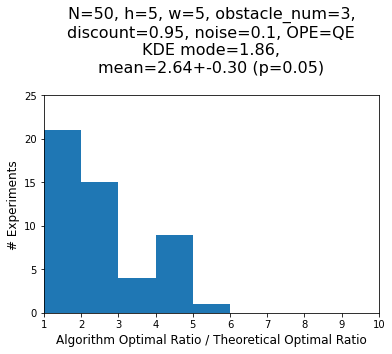

In [65]:
c = 2

bin_num = 10

xtickmax = 10
ytickmax = 25

config = dist_test_configs.iloc[c,:]
samples = (dist_dfs[c]['alg_policy_ratio'] / dist_dfs[c]['opt_ratio'])

xmin = 0.0
xmax = 20.0
pval = 0.05
xs = np.linspace(xmin,xmax,1000)
kde = gaussian_kde(samples)
density = kde.pdf(xs)
argmax = np.argmax(density)
modal = xs[argmax]
ci = st.norm.interval(alpha=1-pval,loc=np.mean(samples),scale=st.sem(samples))
average = samples.mean()
binBoundaries = np.linspace(1,xtickmax,xtickmax)

plt.hist(samples,bins=binBoundaries)
plt.xticks(np.arange(1, xtickmax+1, step=1.0))
plt.yticks(np.arange(0, ytickmax+5, step=5.0))
plt.title('N={}, h={}, w={}, obstacle_num={},\ndiscount={}, noise={}, OPE={}\nKDE mode={:.2f},\nmean={:.2f}+-{:.2f} (p={})\n'.format(config['N'],config['m'],config['n'],config['obstacle_num'],
                              config['discount'],config['noise'],'Simulator' if config['is_theory'] else 'QE',modal,average,(ci[1]-ci[0])/2,pval),fontsize=16)
plt.xlabel('Algorithm Optimal Ratio / Theoretical Optimal Ratio',fontsize=12)
plt.ylabel('# Experiments',fontsize=12)
plt.xlim(1, xtickmax)
plt.ylim(0, ytickmax)
plt.show()

Number of Steps

In [25]:
steps = []

for c, df in dist_dfs.items():
    config = dist_test_configs.iloc[c,:]
    if not config['is_theory']:
        steps.append(df['opt_steps'])
    
steps = pd.concat(steps).values

pval = 0.05
steps_ci = st.norm.interval(alpha=1-pval,loc=np.mean(steps),scale=st.sem(steps))
steps_average = steps.mean()
print('#steps to optimum along theoretical Pareto: {:.2f} +- {:.2f} (p={:.2f})'.format(steps_average,(steps_ci[1]-steps_ci[0])/2,pval))

#steps to optimum along theoretical Pareto: 14.96 +- 0.56 (p=0.05)


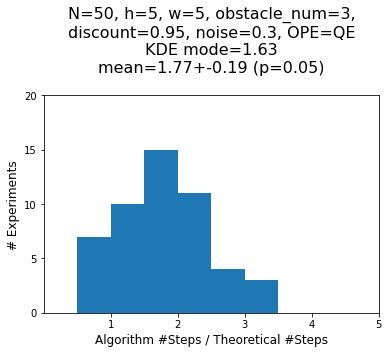

In [67]:
c = 0

config = dist_test_configs.iloc[c,:]
samples = (dist_dfs[c]['alg_steps'] / dist_dfs[c]['opt_steps'])
steps = dist_dfs[c]['opt_steps']

xmin = 0.0
xmax = 5.0
pval = 0.05
xs = np.linspace(xmin,xmax,1000)
kde = gaussian_kde(samples)
density = kde.pdf(xs)
argmax = np.argmax(density)
modal = xs[argmax]
ci = st.norm.interval(alpha=1-pval,loc=np.mean(samples),scale=st.sem(samples))
average = samples.mean()

xtickmax = 5
ytickmax = 20
bin_num = 10

bins = np.linspace(0,xtickmax,bin_num+1)
plt.hist(samples,bins=bins)
plt.xticks(np.arange(1, xtickmax+1, step=1.0))
plt.yticks(np.arange(0, ytickmax+5, step=5.0))
plt.title('N={}, h={}, w={}, obstacle_num={},\ndiscount={}, noise={}, OPE={}\nKDE mode={:.2f}\nmean={:.2f}+-{:.2f} (p={})\n'.format(config['N'],config['m'],config['n'],config['obstacle_num'],
                              config['discount'],config['noise'],'Simulator' if config['is_theory'] else 'QE',modal,average,(ci[1]-ci[0])/2,pval),fontsize=16)
plt.xlabel('Algorithm #Steps / Theoretical #Steps',fontsize=12)
plt.ylabel('# Experiments',fontsize=12)
plt.xlim(0, xtickmax)
plt.ylim(0, ytickmax)
plt.show()

Pareto

In [ ]:
c = 0

if pareto_test_configs.size>0:

    config = pareto_test_configs.iloc[c,:]

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()

    for k, result in enumerate(pareto_results_agg[c]):

        if k==0:

            rewards = result['pareto_rewards']
            risks = result['pareto_risks']

            xs = np.array(risks)
            ys = np.array(rewards) # / np.array(risks)    
            n = ys.argmin()+1

            if n>1:

                for i in range(n-1):
                    if i==0:
                        ax.plot(xs[i:i+2], ys[i:i+2],c='b',alpha=0.5, linewidth=3, label='Theoretical')
                    else:
                        ax.plot(xs[i:i+2], ys[i:i+2],c='b',alpha=0.5, linewidth=3)


        rewards = result['rewards_alg']
        risks = result['risks_alg']

        xs = np.array(risks)
        ys = np.array(rewards) # / np.array(risks)    
        n = xs.size

        for i in range(n-1):
            if i==0 and k==0:
                ax.plot(xs[i:i+2], ys[i:i+2], c='orange', alpha=0.5, linewidth=3, label='Algorithm (Simulator)')
            else:
                ax.plot(xs[i:i+2], ys[i:i+2], c='orange', alpha=0.5, linewidth=3)

        if not pareto_test_configs.iloc[c]['is_theory']:

            rewards = result['rewards_alg_true']
            risks = result['risks_alg_true']

            xs = np.array(risks)
            ys = np.array(rewards) / np.array(risks)    
            n = xs.size

            for i in range(n-1):
                if i==0 and k==0:
                    ax.plot(xs[i:i+2], ys[i:i+2], c='grey', alpha=0.5, linewidth=3, label='Algorithm (QE)')
                else:
                    ax.plot(xs[i:i+2], ys[i:i+2], c='grey', alpha=0.5, linewidth=3)

    ax.set_xlabel(r'Risk $\alpha$', fontsize=18)
    ax.set_ylabel(r'Reward $\mathfrak{r}(\pi)$', fontsize=18)
    # ax.set_ylabel(r'Ratio $\mathfrak{r}(\pi) / \mathfrak{d}(\pi)$', fontsize=18)
    # plt.xticks(np.arange(-5.25, -1.5, step=0.25))
    # plt.yticks(np.arange(0, 0.6, step=0.1))

    ax.grid(which='major', axis='x')
    ax.grid(which='major', alpha=0.6)

    plt.title(r'Pareto Front for the Ratio as a Function of Risk $\alpha$'+'\nN={}, h={}, w={}, obstacle_num={},\ndiscount={}, noise={}, OPE={}'.format(config['N'],config['m'],config['n'],config['obstacle_num'],
                                  config['discount'],config['noise'],'Simulator' if config['is_theory'] else 'QE'),fontsize=18)
    plt.legend(fontsize=14)

    plt.show()            
